In [1]:
# Environment setup and module import
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
debug_encoding = True # if True, uses existing mini_train_clean.csv file so this runs fast
save_data = True # if false, will not save, which takes the most time


In [3]:
# Import DF from CSV

if debug_encoding == True:
    train_file = 'data/mini_train_clean.csv'
    test_file = 'data/mini_test_clean.csv'
    dev_file = 'data/mini_dev_clean.csv'
else:
    train_file = 'data/train_clean.csv'
    test_file = 'data/real_test_clean.csv'
    dev_file = 'data/dev_clean.csv'

train_df = pd.read_csv(train_file, low_memory=False)
test_df = pd.read_csv(test_file, low_memory=False)
dev_df = pd.read_csv(dev_file, low_memory=False)
print("Completed read operations.")

Completed read operations.


In [4]:
def reduce_mem(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def make_subsets(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_cols = [c for c,v in df.dtypes.items() if v in numerics and c in df.columns]
    nominal_cols = [c for c in df.columns if (c not in numeric_cols)]
    binary_cols = [c for c in df.columns if (df[c].nunique() == 2 and c not in nominal_cols)]
    labels = df["HasDetections"].values
    return numeric_cols, nominal_cols, binary_cols, labels

def transform_df(in_df, nominal_cols):
    le = preprocessing.LabelEncoder()
    df = in_df[nominal_cols].apply(le.fit_transform)
    for c in in_df.loc[:, in_df.dtypes == np.int8].columns:
        df[c] = in_df[c]
    for c in in_df.loc[:, in_df.dtypes == np.int16].columns:
        df[c] = train_df[c]
    for c in in_df.loc[:, in_df.dtypes == np.int32].columns:
        df[c] = in_df[c]
    for c in in_df.loc[:, in_df.dtypes == np.float16].columns:
        df[c] = in_df[c]
    for c in in_df.loc[:, in_df.dtypes == np.float32].columns:
        df[c] = in_df[c]
    for c in in_df[in_df.select_dtypes(bool).columns]:
        df[c] = in_df[c]
    return df

def make_encoded_version_column(df, col):
    df[col] = df[col+'_major'] * 10000000 + df[col+'_minor'] * 100000 + df[col+'_build1'] * 1000 + df[col+'_build2']
    return df#.drop(columns=[col+'_major', col+'_minor',col+'_build1', col+'_build2'])

def std_norm(df):
    col_to_std = ['AVProductStatesIdentifier','CountryIdentifier','CityIdentifier','GeoNameIdentifier','LocaleEnglishNameIdentifier','OsBuild','IeVerIdentifier','Census_OEMNameIdentifier','Census_OEMModelIdentifier','Census_ProcessorCoreCount','Census_ProcessorModelIdentifier','Census_PrimaryDiskTotalCapacity','Census_SystemVolumeTotalCapacity','Census_TotalPhysicalRAM','Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal','Census_InternalPrimaryDisplayResolutionVertical','Census_InternalBatteryNumberOfCharges','Census_OSBuildNumber','Census_OSInstallLanguageIdentifier','Census_OSUILocaleIdentifier','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Wdft_RegionIdentifier','OsBuildLab_major','OsBuildLab_minor','OsBuildLab_platform','OsBuildLab_release','OsBuildLab_build2']
    scaled_features = df.copy()
    features = scaled_features[col_to_std]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_features[col_to_std] = features
    df = scaled_features
    return df

In [5]:
# Clean up memory
train_df = reduce_mem(train_df)
test_df = reduce_mem(test_df)
dev_df = reduce_mem(dev_df)
gc.collect()

Memory usage of dataframe is 282.00 MB
Memory usage after optimization is: 81.25 MB
Decreased by 71.2%
Memory usage of dataframe is 60.43 MB
Memory usage after optimization is: 17.45 MB
Decreased by 71.1%
Memory usage of dataframe is 60.43 MB
Memory usage after optimization is: 17.58 MB
Decreased by 70.9%


11

In [6]:
# Define dtypes and references to column subsets

train_numeric_cols, train_nominal_cols, train_binary_cols, train_labels = make_subsets(train_df)
test_numeric_cols, test_nominal_cols, test_binary_cols, test_labels = make_subsets(test_df)
dev_numeric_cols, dev_nominal_cols, dev_binary_cols, dev_labels = make_subsets(dev_df)

print("done selecting column types")

done selecting column types


In [7]:
# Encode select features with version numbers

# Encode remaining nominal variables as labels

# TO REMOVE AFTER CLEANUP, ANDREW:
train_nominal_cols.remove('SmartScreen')
test_nominal_cols.remove('SmartScreen')
dev_nominal_cols.remove('SmartScreen')

le = preprocessing.LabelEncoder()
for n in train_nominal_cols:
    train_df[n] = le.fit_transform(train_df[n])
le = preprocessing.LabelEncoder()
for n in test_nominal_cols:
    test_df[n] = le.fit_transform(test_df[n])
le = preprocessing.LabelEncoder()
for n in dev_nominal_cols:
    dev_df[n] = le.fit_transform(dev_df[n])
    
print("done encoding version columns")

done encoding version columns


In [8]:
# Encode labels so that they can be flattened into an arra
train_df = transform_df(train_df, train_nominal_cols)
test_df = transform_df(test_df, test_nominal_cols)
dev_df = transform_df(dev_df, dev_nominal_cols)


In [9]:
# Standardize and normalize

train_df = std_norm(train_df)
test_df = std_norm(test_df)
dev_df = std_norm(dev_df)



(312251, 148)
ProductName plot:


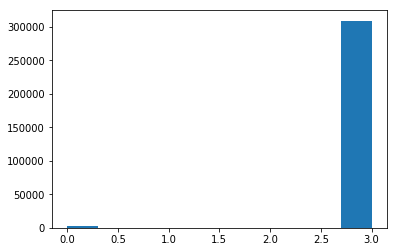

EngineVersion plot:


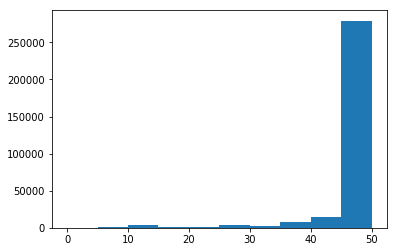

AppVersion plot:


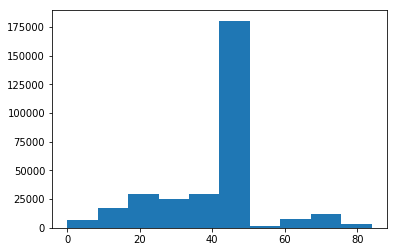

AvSigVersion plot:


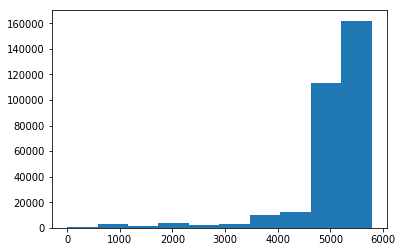

Platform plot:


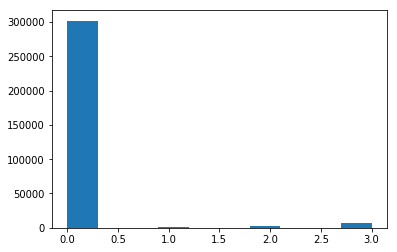

Processor plot:


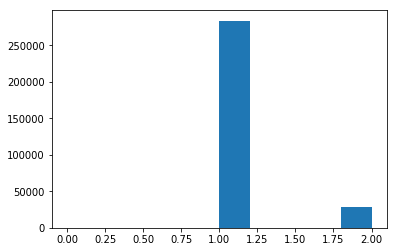

OsVer plot:


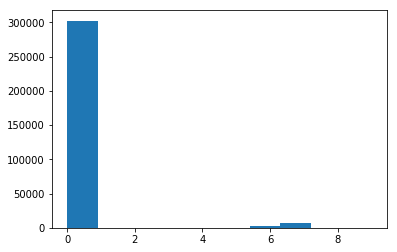

OsPlatformSubRelease plot:


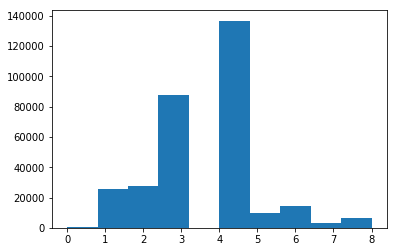

OsBuildLab plot:


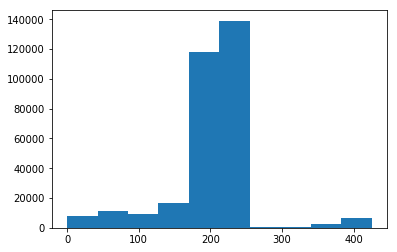

SkuEdition plot:


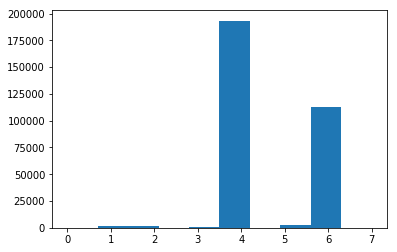

PuaMode plot:


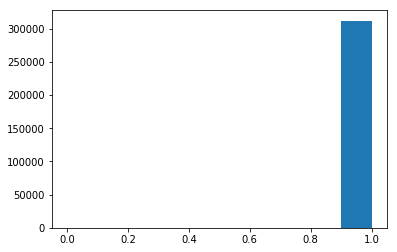

Census_MDC2FormFactor plot:


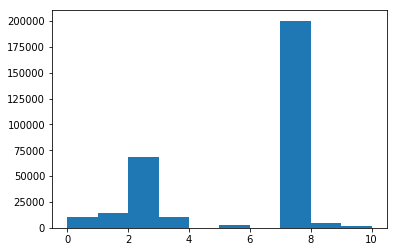

Census_DeviceFamily plot:


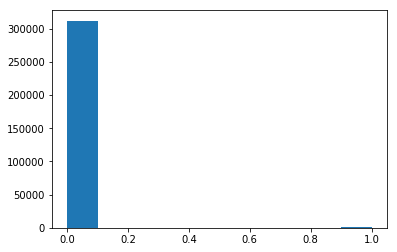

Census_ProcessorClass plot:


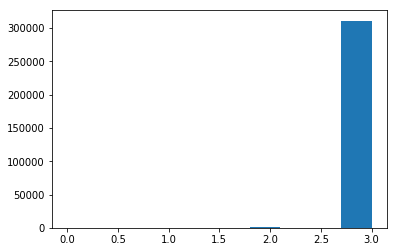

Census_PrimaryDiskTypeName plot:


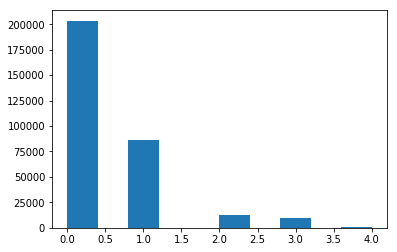

Census_ChassisTypeName plot:


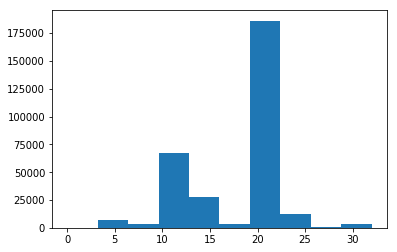

Census_PowerPlatformRoleName plot:


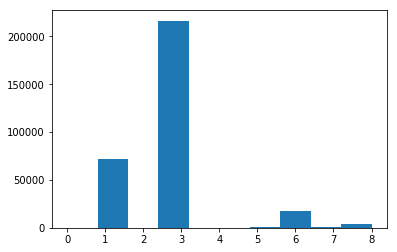

Census_InternalBatteryType plot:


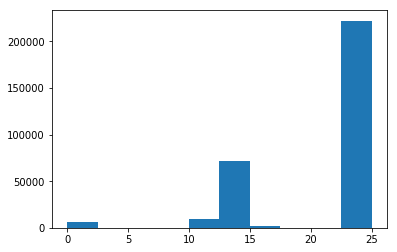

Census_OSVersion plot:


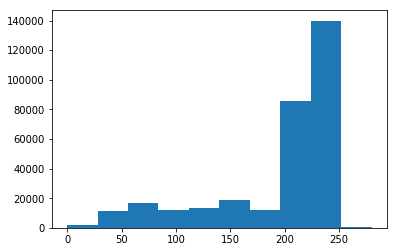

Census_OSArchitecture plot:


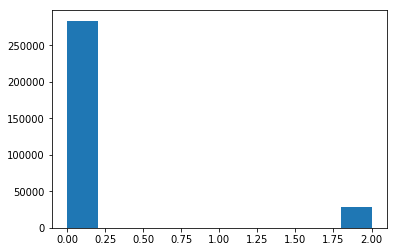

Census_OSBranch plot:


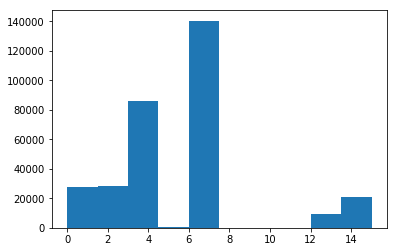

Census_OSEdition plot:


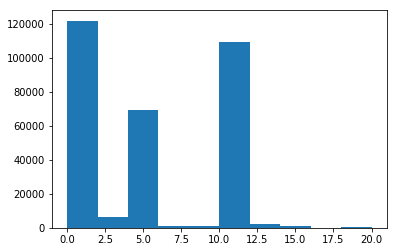

Census_OSSkuName plot:


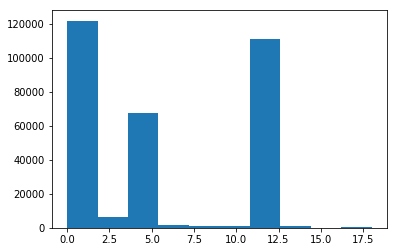

Census_OSInstallTypeName plot:


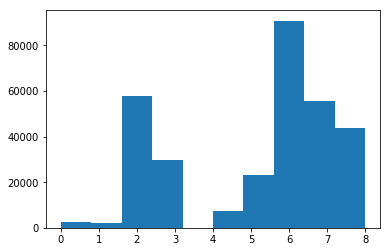

Census_OSWUAutoUpdateOptionsName plot:


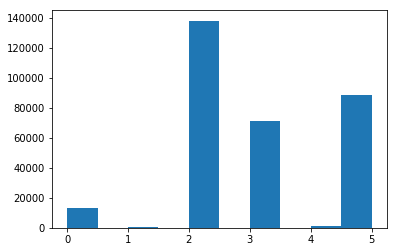

Census_GenuineStateName plot:


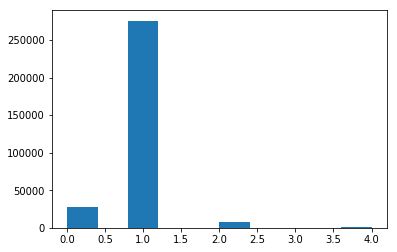

Census_ActivationChannel plot:


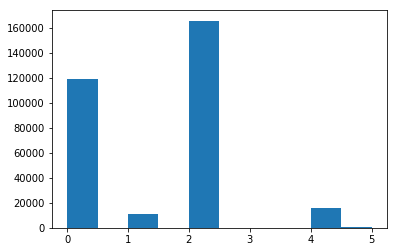

Census_FlightRing plot:


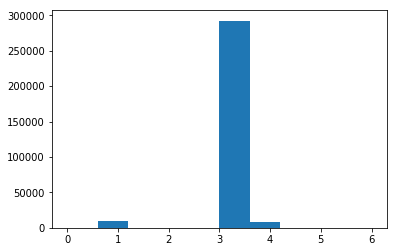

OsBuildLab_platform plot:


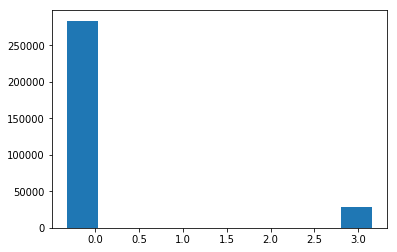

OsBuildLab_release plot:


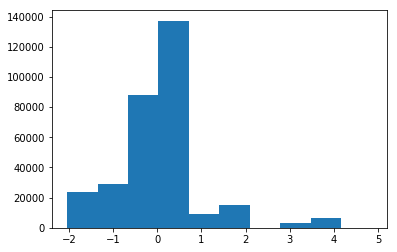

IsBeta plot:


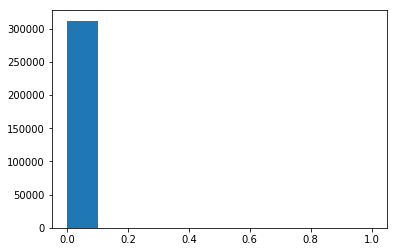

RtpStateBitfield plot:


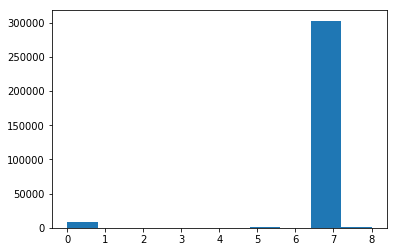

IsSxsPassiveMode plot:


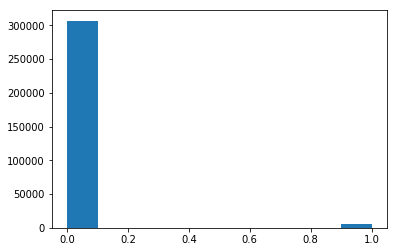

HasTpm plot:


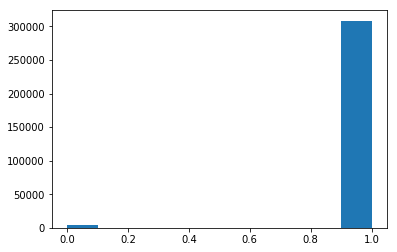

AutoSampleOptIn plot:


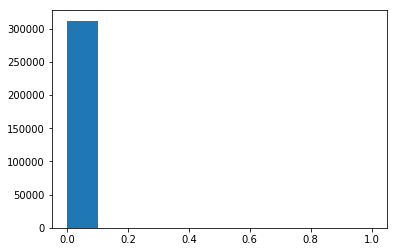

Census_HasOpticalDiskDrive plot:


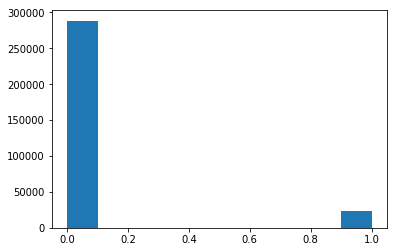

Census_IsPortableOperatingSystem plot:


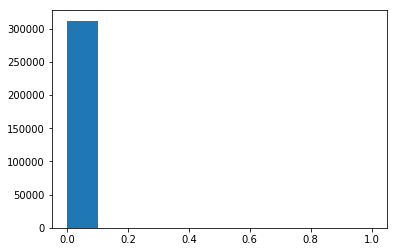

Census_IsSecureBootEnabled plot:


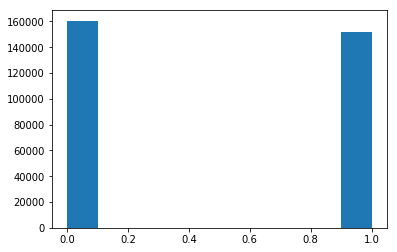

Census_IsTouchEnabled plot:


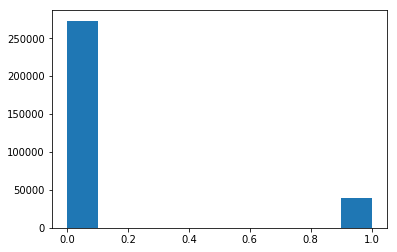

Census_IsPenCapable plot:


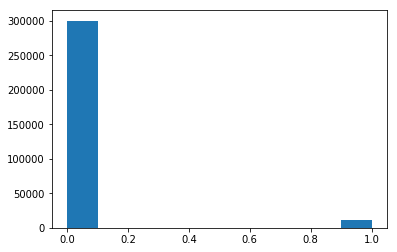

HasDetections plot:


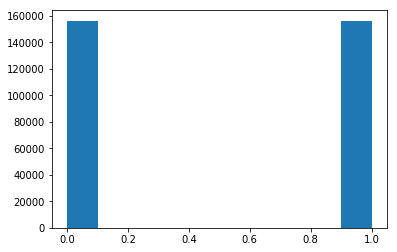

EngineVersion_major plot:


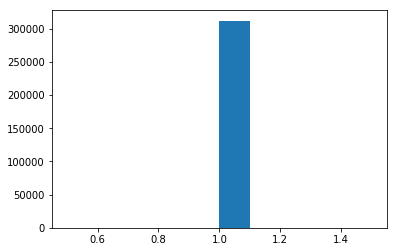

EngineVersion_minor plot:


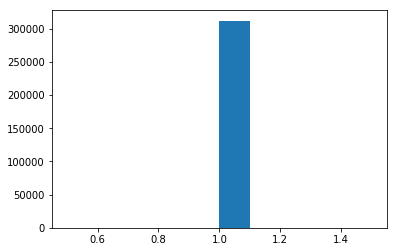

EngineVersion_build2 plot:


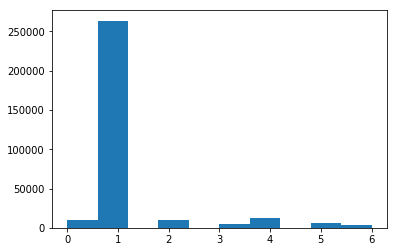

AppVersion_major plot:


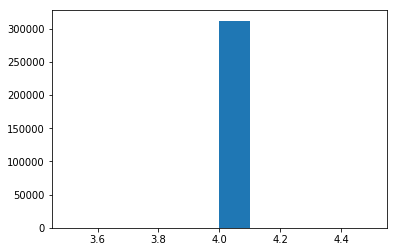

AppVersion_minor plot:


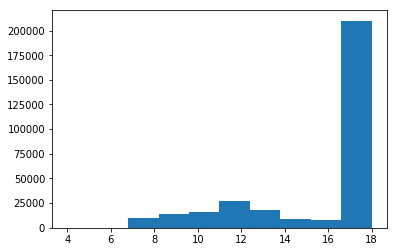

AvSigVersion_major plot:


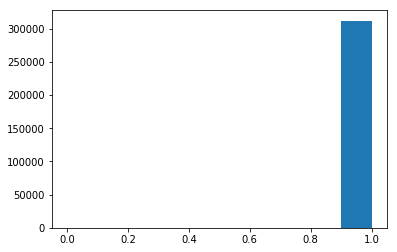

AvSigVersion_build2 plot:


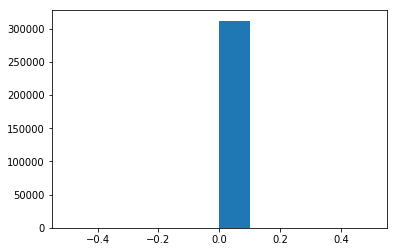

Census_OSVersion_major plot:


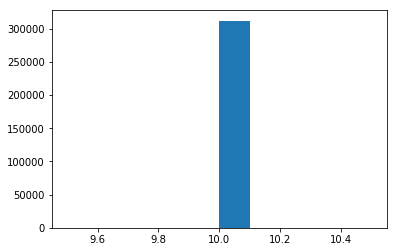

Census_OSVersion_minor plot:


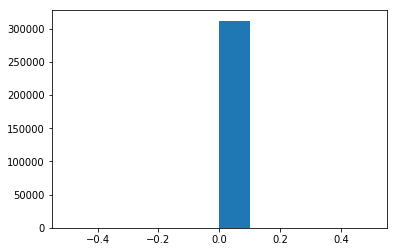

OsVer_major plot:


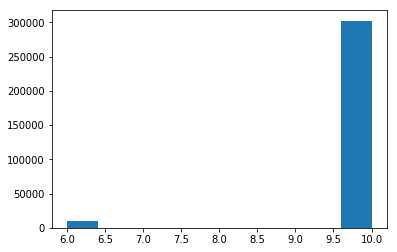

OsVer_minor plot:


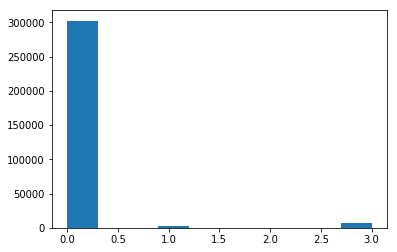

OsVer_build1 plot:


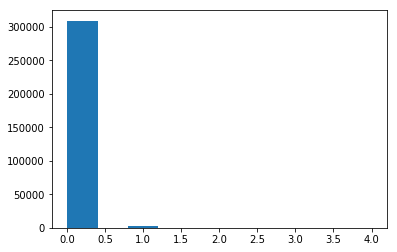

OsVer_build2 plot:


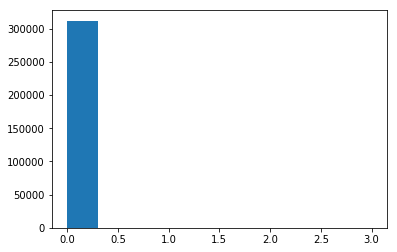

CountryIdentifier plot:


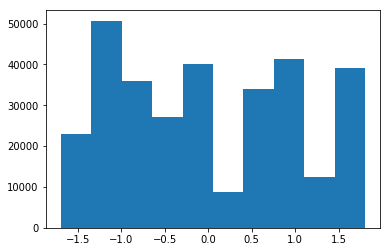

LocaleEnglishNameIdentifier plot:


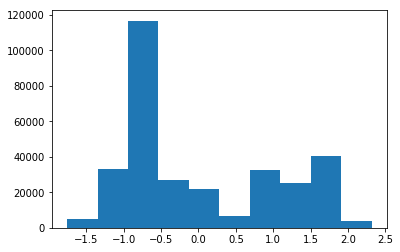

OsBuild plot:


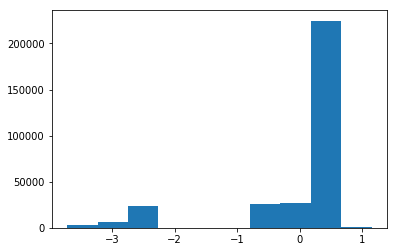

OsSuite plot:


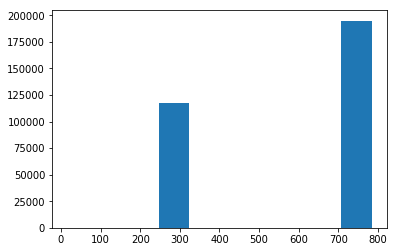

Census_OSBuildNumber plot:


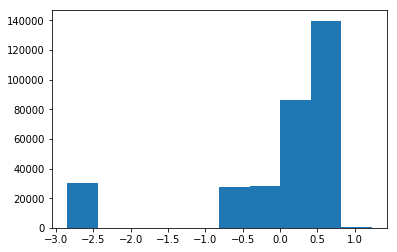

Census_OSBuildRevision plot:


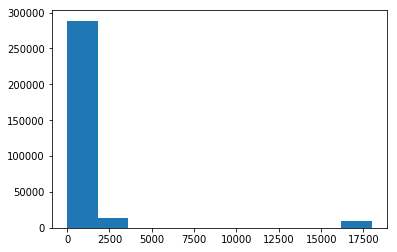

Census_OSUILocaleIdentifier plot:


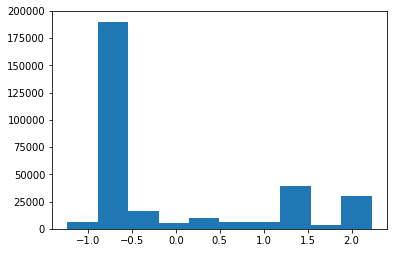

EngineVersion_build1 plot:


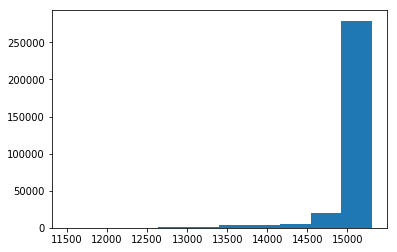

AppVersion_build1 plot:


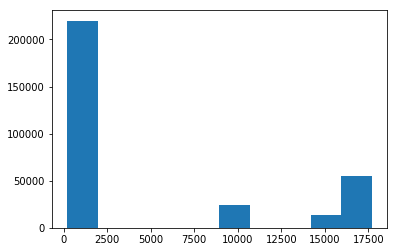

AppVersion_build2 plot:


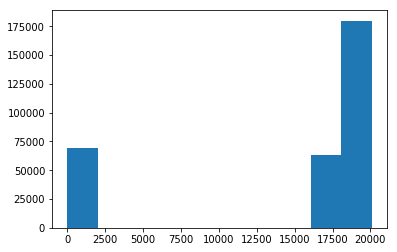

AvSigVersion_minor plot:


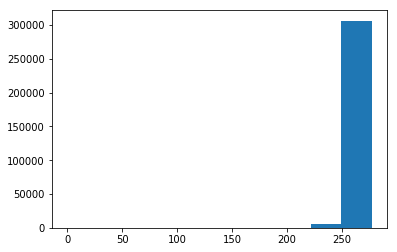

AvSigVersion_build1 plot:


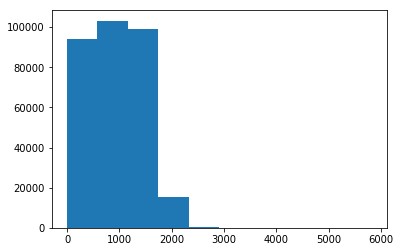

Census_OSVersion_build1 plot:


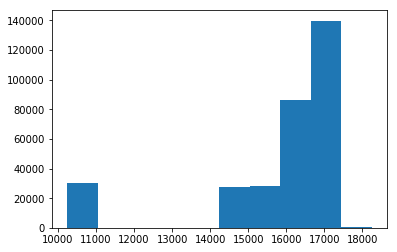

Census_OSVersion_build2 plot:


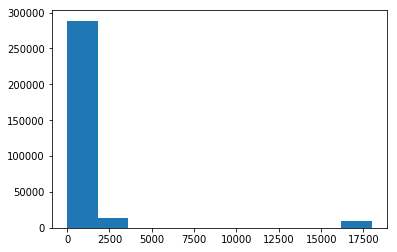

OsBuildLab_major plot:


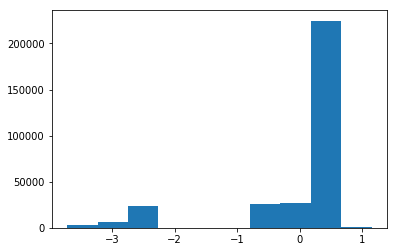

OsBuildLab_minor plot:


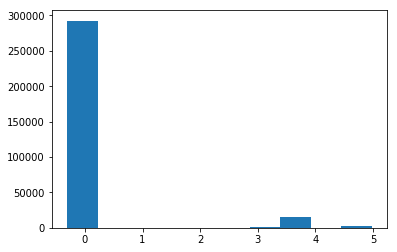

OsBuildLab_build2 plot:


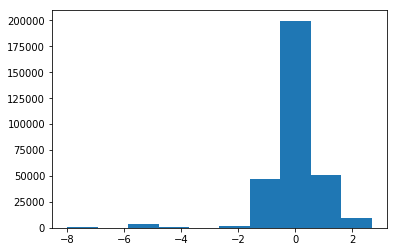

OsBuildLab_build1 plot:


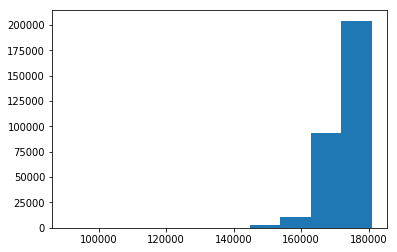

DefaultBrowsersIdentifier plot:


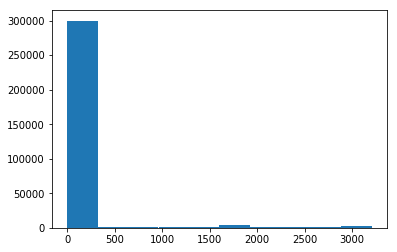

AVProductsInstalled plot:


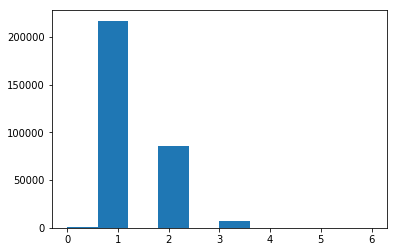

AVProductsEnabled plot:


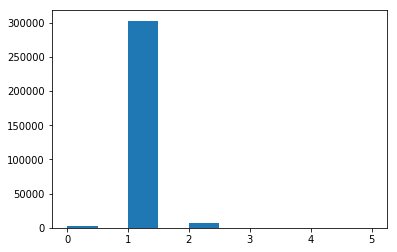

OrganizationIdentifier plot:


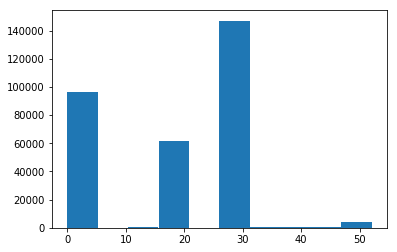

GeoNameIdentifier plot:


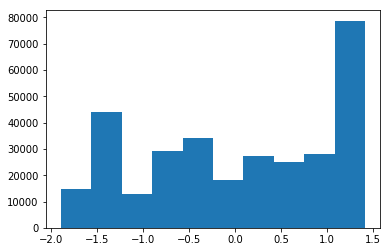

IsProtected plot:


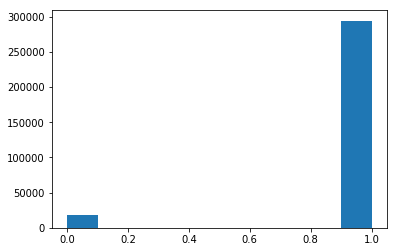

SMode plot:


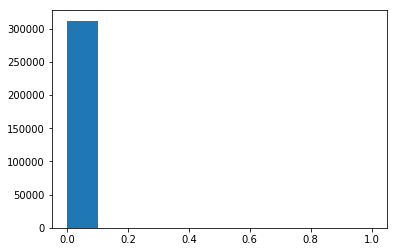

IeVerIdentifier plot:


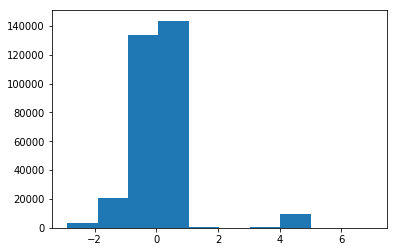

Firewall plot:


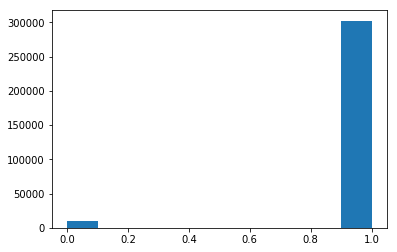

Census_OEMNameIdentifier plot:


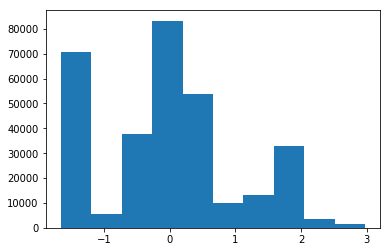

Census_ProcessorCoreCount plot:


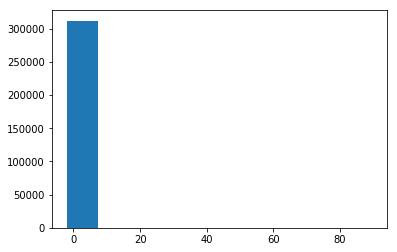

Census_ProcessorManufacturerIdentifier plot:


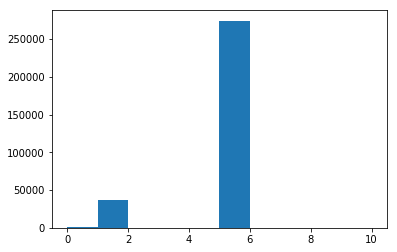

Census_ProcessorModelIdentifier plot:


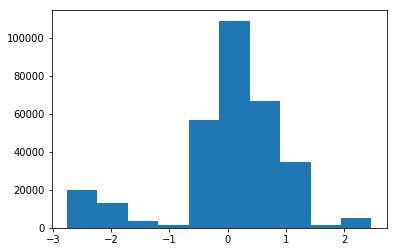

Census_InternalPrimaryDiagonalDisplaySizeInInches plot:


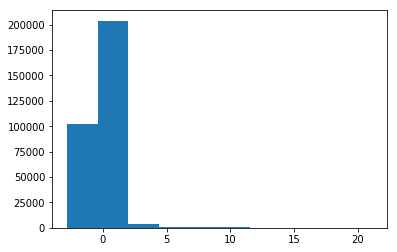

Census_InternalPrimaryDisplayResolutionHorizontal plot:


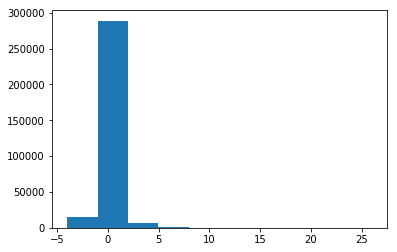

Census_InternalPrimaryDisplayResolutionVertical plot:


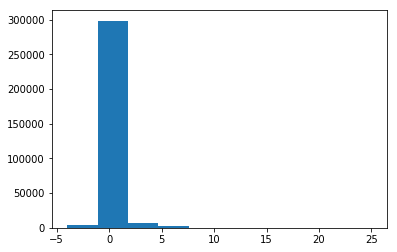

Census_OSInstallLanguageIdentifier plot:


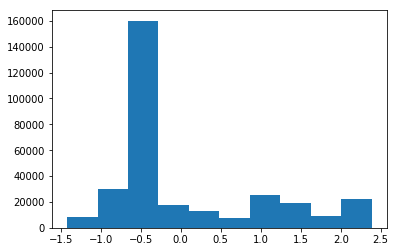

Census_IsFlightingInternal plot:


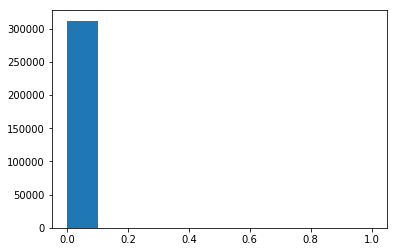

Census_IsFlightsDisabled plot:


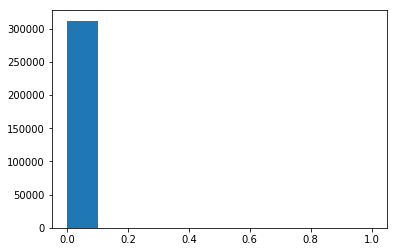

Census_ThresholdOptIn plot:


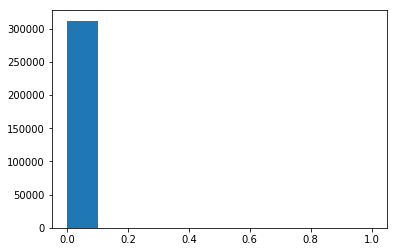

Census_FirmwareManufacturerIdentifier plot:


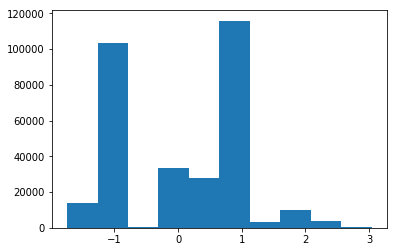

Census_IsWIMBootEnabled plot:


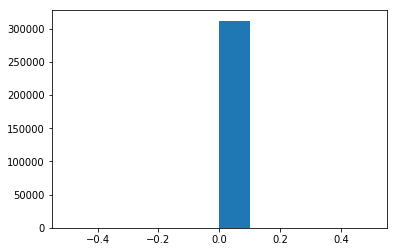

Census_IsVirtualDevice plot:


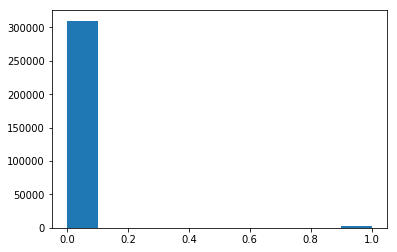

Census_IsAlwaysOnAlwaysConnectedCapable plot:


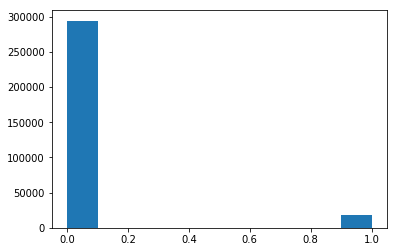

Wdft_IsGamer plot:


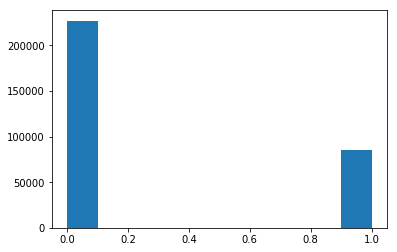

Wdft_RegionIdentifier plot:


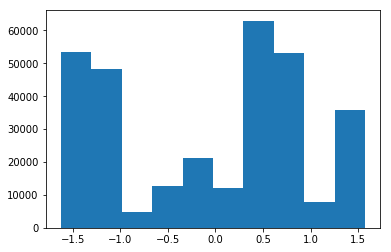

RtpStateBitfield_wasna plot:


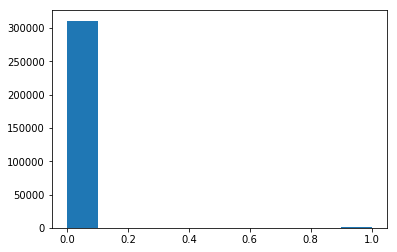

DefaultBrowsersIdentifier_wasna plot:


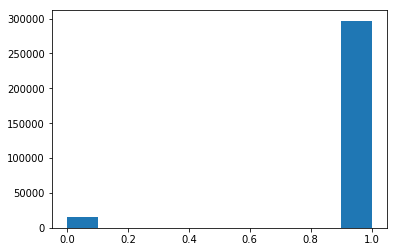

AVProductStatesIdentifier_wasna plot:


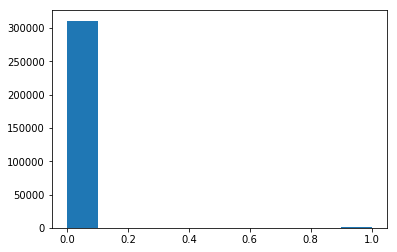

AVProductsInstalled_wasna plot:


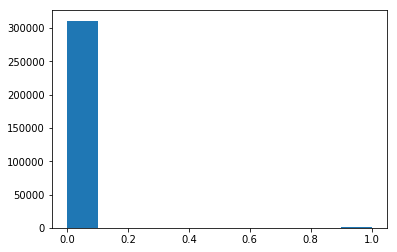

AVProductsEnabled_wasna plot:


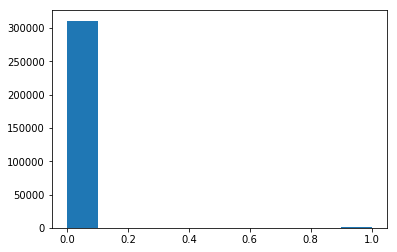

CityIdentifier_wasna plot:


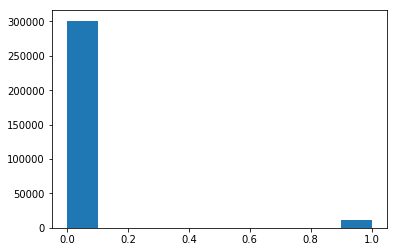

OrganizationIdentifier_wasna plot:


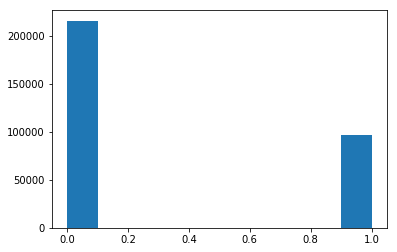

GeoNameIdentifier_wasna plot:


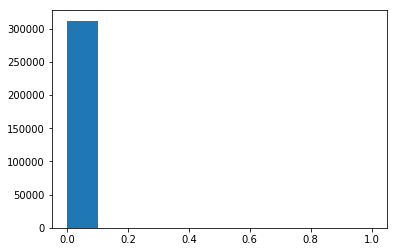

IsProtected_wasna plot:


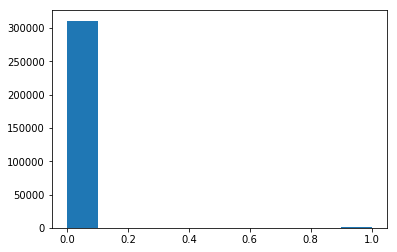

SMode_wasna plot:


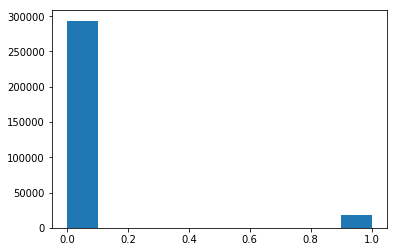

IeVerIdentifier_wasna plot:


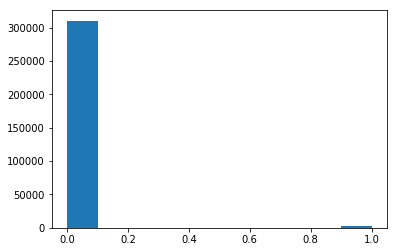

Firewall_wasna plot:


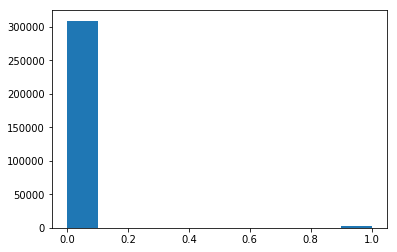

UacLuaenable_wasna plot:


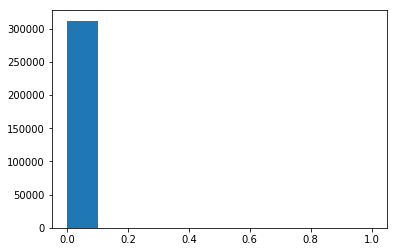

Census_OEMNameIdentifier_wasna plot:


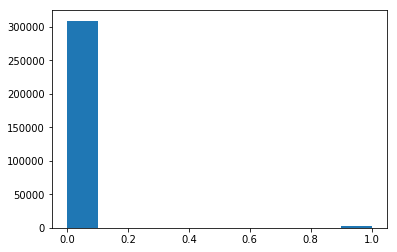

Census_OEMModelIdentifier_wasna plot:


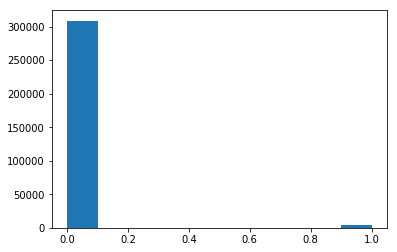

Census_ProcessorCoreCount_wasna plot:


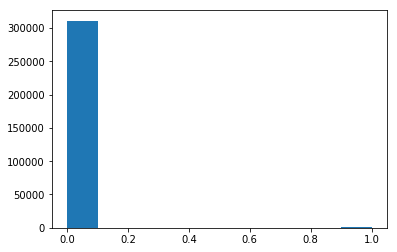

Census_ProcessorManufacturerIdentifier_wasna plot:


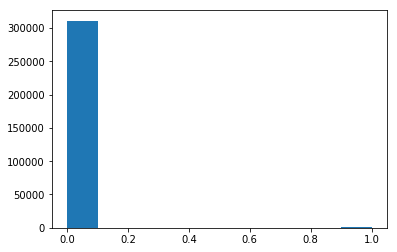

Census_ProcessorModelIdentifier_wasna plot:


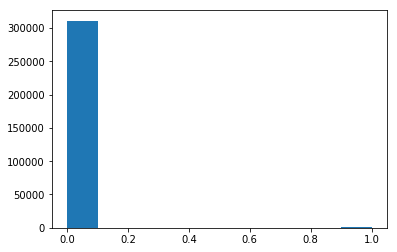

Census_PrimaryDiskTotalCapacity_wasna plot:


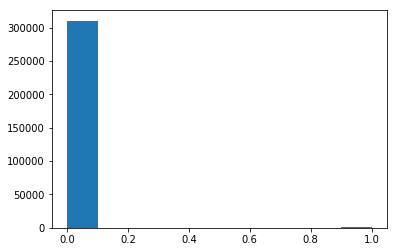

Census_SystemVolumeTotalCapacity_wasna plot:


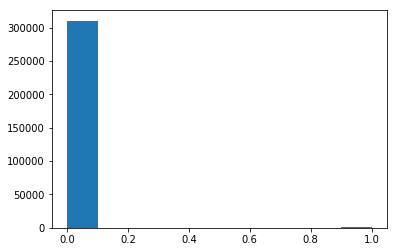

Census_TotalPhysicalRAM_wasna plot:


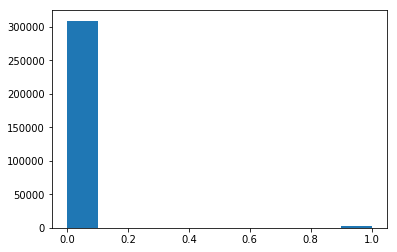

Census_InternalPrimaryDiagonalDisplaySizeInInches_wasna plot:


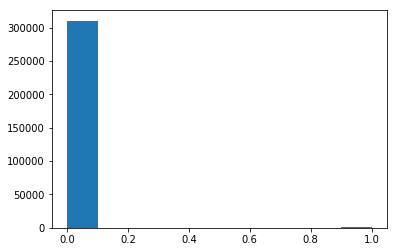

Census_InternalPrimaryDisplayResolutionHorizontal_wasna plot:


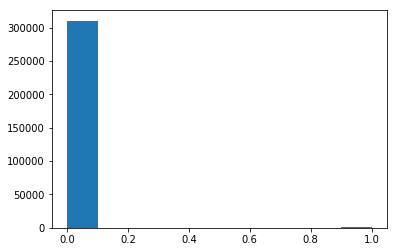

Census_InternalPrimaryDisplayResolutionVertical_wasna plot:


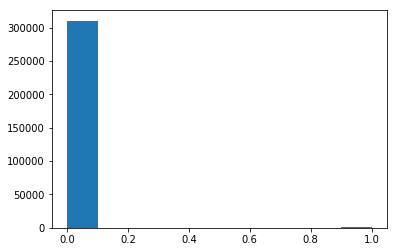

Census_InternalBatteryNumberOfCharges_wasna plot:


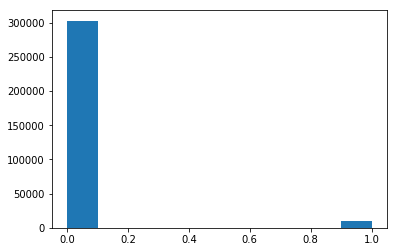

Census_OSInstallLanguageIdentifier_wasna plot:


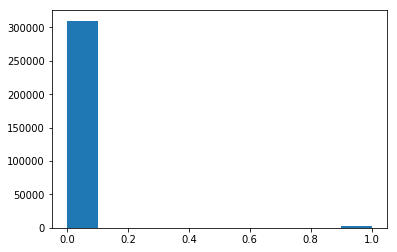

Census_IsFlightingInternal_wasna plot:


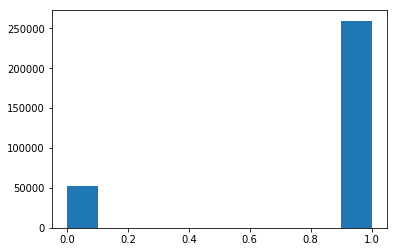

Census_IsFlightsDisabled_wasna plot:


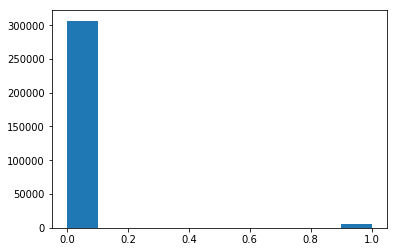

Census_ThresholdOptIn_wasna plot:


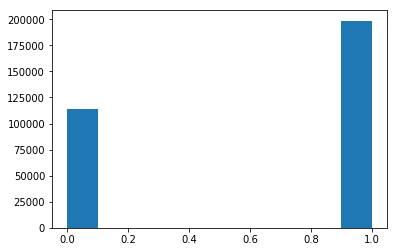

Census_FirmwareManufacturerIdentifier_wasna plot:


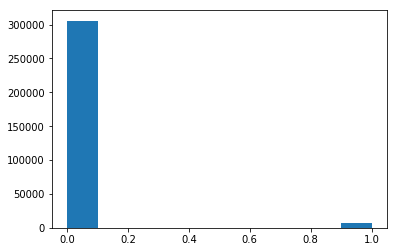

Census_IsWIMBootEnabled_wasna plot:


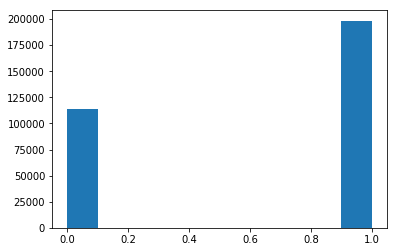

Census_IsVirtualDevice_wasna plot:


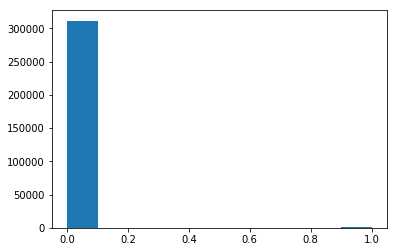

Census_IsAlwaysOnAlwaysConnectedCapable_wasna plot:


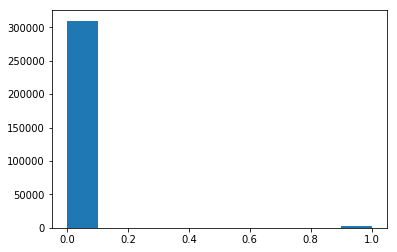

Wdft_IsGamer_wasna plot:


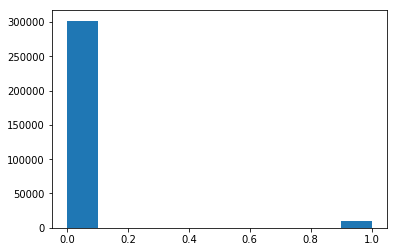

Wdft_RegionIdentifier_wasna plot:


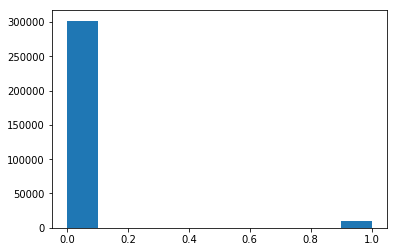

EngineVersion_combined plot:


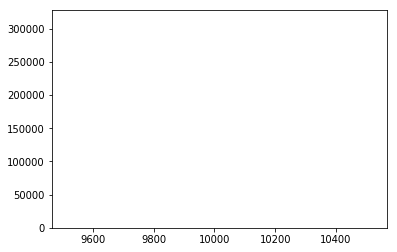

AppVersion_combined plot:


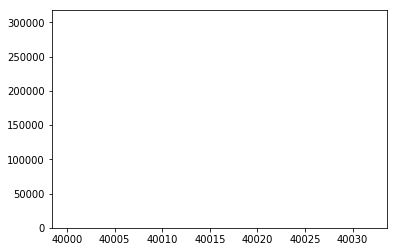

AvSigVersion_combined plot:


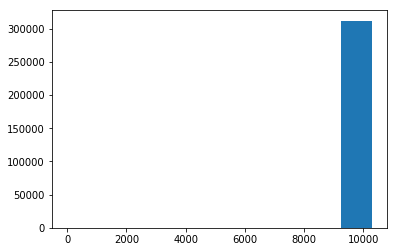

AVProductStatesIdentifier plot:


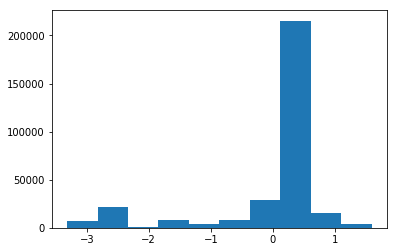

CityIdentifier plot:


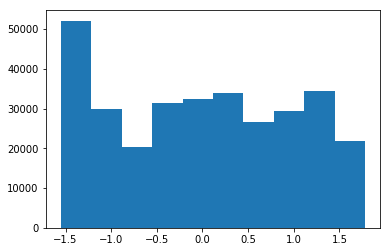

UacLuaenable plot:


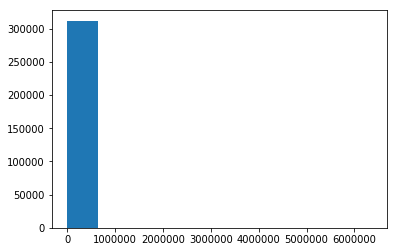

Census_OEMModelIdentifier plot:


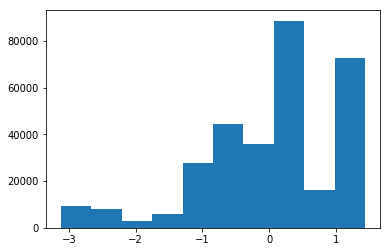

Census_PrimaryDiskTotalCapacity plot:


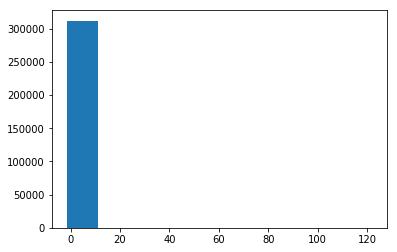

Census_SystemVolumeTotalCapacity plot:


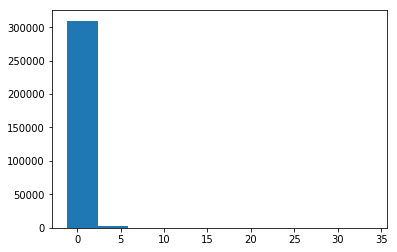

Census_TotalPhysicalRAM plot:


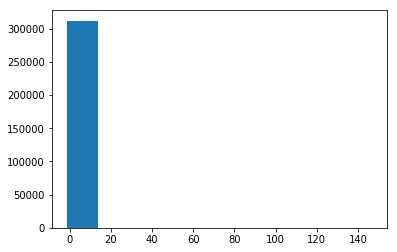

Census_InternalBatteryNumberOfCharges plot:


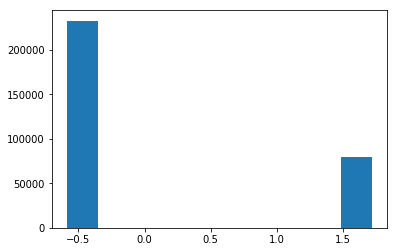

Census_FirmwareVersionIdentifier plot:


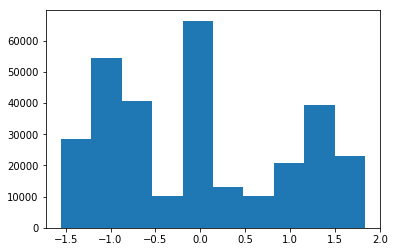

Census_OSVersion_combined plot:


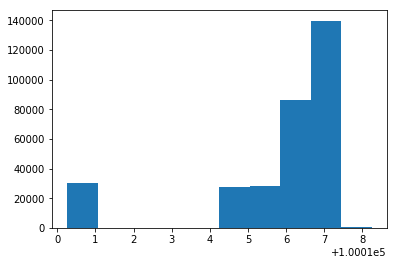

OsVer_combined plot:


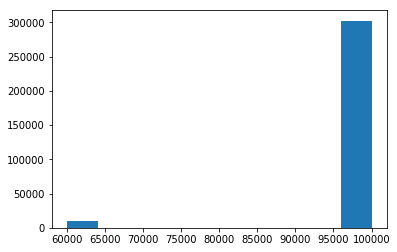

OsBuildLab_combined plot:


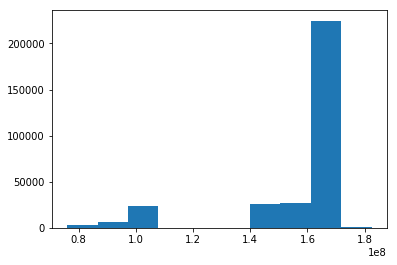

In [10]:
#Verify output

print(train_df.shape)

for n in train_df.columns:
    print(n,"plot:")
    plt.hist(train_df[n].dropna())
    plt.show()

In [11]:
# Save to export file
if save_data == True:
    if debug_encoding == False:
        # Write to production files
        train_file = 'data/train_encoded.csv'
        test_file = 'data/test_encoded.csv'
        dev_file = 'data/dev_encoded.csv'
        train_df.to_csv(train_file)
        test_df.to_csv(test_file)
        dev_df.to_csv(dev_file)
    # write to mini files either way
    train_file = 'data/mini_train_encoded.csv'
    test_file = 'data/mini_test_encoded.csv'
    dev_file = 'data/mini_dev_encoded.csv'
    train_df.to_csv(train_file)
    test_df.to_csv(test_file)
    dev_df.to_csv(dev_file)
    print("Output saved.")
else:
    print("Output not saved.")

Output saved.
